In [27]:
import os
import random
import kagglehub
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import numpy as np

Step 1: Downloading Dataset

In [11]:
dataset_path = kagglehub.dataset_download("kapillondhe/american-sign-language")
#alternatively locally:
# dataset_path=r"C:\Users\pauls\PycharmProjects\NN_labs\Project2"
print(f"Dataset downloaded to: {dataset_path}")
if 'ASL_Dataset' in os.listdir(dataset_path):
    data_dir = os.path.join(dataset_path, r'ASL_Dataset\Train')
else:
    data_dir = dataset_path

print(f"Target Data Directory: {data_dir}")

Dataset downloaded to: C:\Users\pauls\.cache\kagglehub\datasets\kapillondhe\american-sign-language\versions\1
Target Data Directory: C:\Users\pauls\.cache\kagglehub\datasets\kapillondhe\american-sign-language\versions\1\ASL_Dataset\Train


EXPLORATORY DATA ANALYSIS

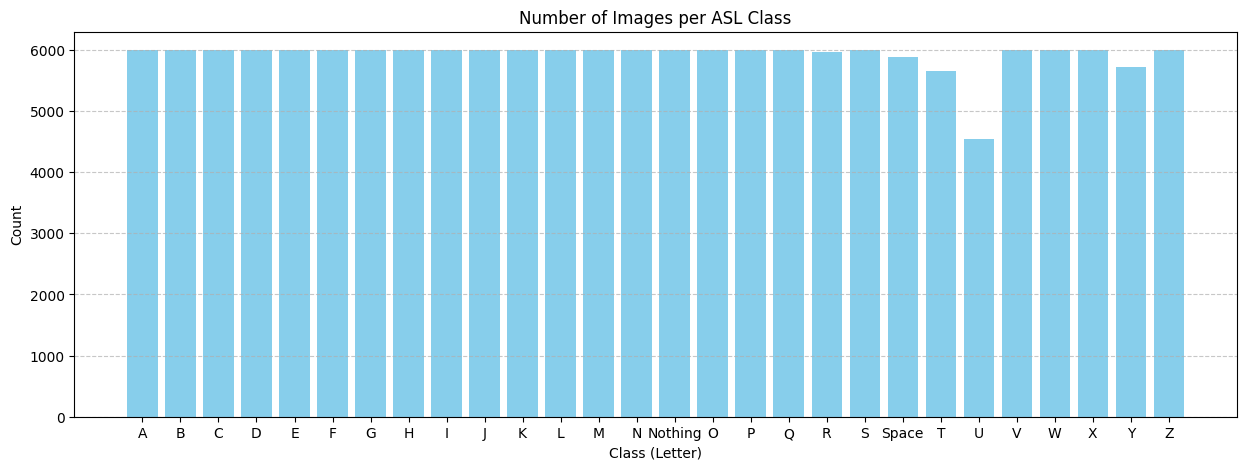

In [12]:
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_counts = {}

# Loop through each class folder and count the images
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    # Only count files that end with image extension
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    class_counts[class_name] = count

# Plotting the distribution
plt.figure(figsize=(15, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Number of Images per ASL Class')
plt.xlabel('Class (Letter)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In general classes evenly balanced, except for "U"

In [13]:
min_count = min(class_counts.values())
max_count = max(class_counts.values())
print(f"Minimum images in a class: {min_count}")
print(f"Maximum images in a class: {max_count}")

Minimum images in a class: 4542
Maximum images in a class: 5996


Some RANDOM samples

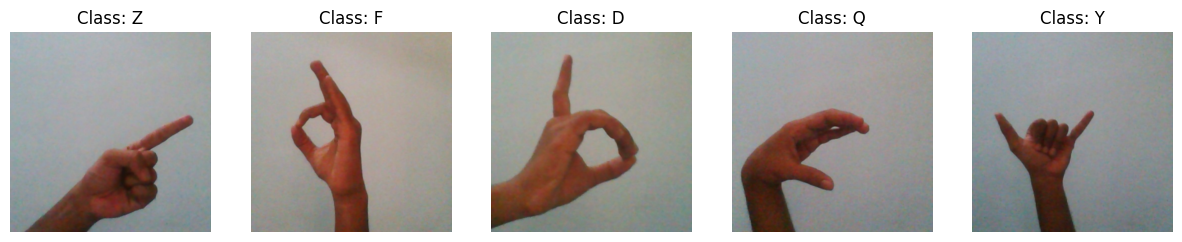

In [17]:
def show_random_images(base_path, class_list, num_images=5):
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        #Pick a random clas
        random_class = random.choice(class_list)
        class_path = os.path.join(base_path, random_class)

        #Pick a random image inside that class
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random_image = random.choice(images)

        #Load image
        img_path = os.path.join(class_path, random_image)
        img = plt.imread(img_path)

        #Display
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Class: {random_class}")
        plt.axis('off')

    plt.show()

show_random_images(data_dir, classes)

PREPROCESSING & AUGMENTATION
1) No flipping, because then the hand sign might lose its meaning. Doing small rotations for augmentation (like naturally hand could be a little turned)

In [22]:
train_transforms = transforms.Compose([
    #Resizing to a fixed small size
    transforms.Resize((64, 64)),

    #rotate the hand slightly (+/- 10 degrees).
    transforms.RandomRotation(10),
    #"Normalization" - Converts the image (0-255 pixels) into a PyTorch Tensor (0-1 values)
    transforms.ToTensor(),
    #possibility to normalize with mean mu and std (0.5 and 0.5)?
    # (Input - Mean) / Std
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
val_test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # No rotation for validation!!
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [23]:
full_dataset = ImageFolder(root=data_dir, transform=train_transforms)

print(f"Total images loaded into dataset: {len(full_dataset)}")

Total images loaded into dataset: 165670


SPLIT TRAIN, VAL, TEST.
There is already a separate TEST directory. So Just split the train directory in 80/20 Train/Validation set

In [24]:
train_dir = os.path.join(dataset_path, r'ASL_Dataset\Train')
test_dir = os.path.join(dataset_path, r'ASL_Dataset\Test')
full_train_data = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)
train_size = int(0.8 * len(full_train_data))
val_size = len(full_train_data) - train_size
train_dataset, val_dataset = random_split(full_train_data, [train_size, val_size])

#Clean validation set (no rotation)
val_dataset.dataset.transform = val_test_transforms
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(val_dataset)}")
print(f"Test Images: {len(test_dataset)}")

Training Images: 132536
Validation Images: 33134
Test Images: 112


DATA LOADERS

In [26]:
BATCH_SIZE = 32
# Train Loader: Shuffle=True, so that MODEL SEES random classes,
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val/Test Loaders: Shuffle=False. No shuffle during evaluation
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check one batch
images, labels = next(iter(train_loader))

print(f"Batch Image Shape: {images.shape}")
#[Batch_Size, Channels(RGB), Height, Width]
print(f"Batch Label Shape: {labels.shape}")
#[32] -> One label number per image

Batch Image Shape: torch.Size([32, 3, 64, 64])
Batch Label Shape: torch.Size([32])


EVALUATION METRICS


Multi-Class Classification problem, classes are more or less blaanced --> Accuracy would be the most important metric.


Will use CONFUSION MATRIX, to understand WHERE the model is struggling.


Per-class Precision (When the model predicted 'A', how often was it actually 'A') and
Recall (Out of all the 'A' images in the test set, how many did the model find?

Loss Curves for model training eval
